In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 需要调用处理模块，我们运行以上级目录运行调用的包的名字可以不变
import sys
sys.path.append('../')
sys.path.append('./')

slim = tf.contrib.slim


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# 需要用到预处理工厂，模型工厂
from OnlineClsaa.nets import nets_factory
from OnlineClsaa.preprocessing import preprocessing_factory
from OnlineClsaa.utils.basic_tools import np_methods
from OnlineClsaa.test import visualization

In [3]:
# 使用feed_dic 与placeholder的形式，运行时输入数据

In [4]:
# 1.定义数据输入图片数据的占位符
image_input = tf.placeholder(tf.uint8, shape=(None, None, 3))

In [5]:
# 定义一个输出的形状，元祖表示
net_shape = (300, 300)
data_format = "NHWC"

In [6]:
# 2、数据输入到预处理工厂当中，进行处理得到结果
preprocessing_fn = preprocessing_factory.get_preprocessing("ssd_vgg_300", is_training=False)

img_pre, _, _,bbox_img= preprocessing_fn(image_input, None, None, net_shape, data_format)
# img_pre是三维形状，(300, 300, 3)
# 卷积神经网络要求都是四维的数据计算(1, 300, 300, 3)
# 维度的扩充
image_4d = tf.expand_dims(img_pre, 0)


Instructions for updating:
Use tf.cast instead.


In [7]:
# 3、定义SSD模型， 并输出预测结果
# reuse作用：在notebook当中运行，第一次创建新的变量为FALSE，但是重复运行cell,保留这些变量的命名，选择重用这些命名，已经存在内存当中了
# 没有消除，设置reuse=True
reuse = True if 'ssd_net' in locals() else False

In [8]:
# 网络工厂获取
ssd_class = nets_factory.get_network("ssd_vgg_300")
# 网络类当中参数，类别总数（商品数据集8+1）？
ssd_params = ssd_class.default_params._replace(num_classes=9)
# 初始化网络
ssd_net = ssd_class(ssd_params)

# 通过网络的方法获取结果
# 使用slim指定共有参数data_format,net函数里面有很多函数需要使用data_format
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


In [9]:
ssd_anchors = ssd_net.anchors(net_shape)

In [ ]:
# 4.定义交互式会话，初始化变量，加载模型
config = tf.ConfigProto(log_device_placement=False)
isess = tf.InteractiveSession(config=config)
isess.run(tf.global_variables_initializer())
# object_detection/OnlineClsaa/ckpt/pre_training
ckpt_filename ="object_detection/OnlineClsaa/ckpt/pre_training/model.ckpt-85863"
# 创建一个saver加载模型
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [10]:
# 会话运行图片，输出结果
# 读取一张图片
img = Image.open("./IMAGE/commodity/JPEGImages/000052.jpg").convert('RGB')
# 走一个数组转换
img = np.array(img)

r, p, l, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={image_input: img})

ERROR! Session/line number was not unique in database. History logging moved to new session 79


In [11]:
p# 通过 predictions 与 select_threshold 筛选bbox
classes, scores, bboxes = np_methods.ssd_bboxes_select(
    p, l, ssd_anchors,
    select_threshold=0.15, img_shape=(300, 300), num_classes=9, decode=True)
# bbox边框不能超过原图片 默认原图的相对于bbox大小比例 [0, 0, 1, 1]
bboxes = np_methods.bboxes_clip(rbbox_img, bboxes)
# 根据 scores 从大到小排序，并改变classes rbboxes的顺序
classes, scores, bboxes = np_methods.bboxes_sort(classes, scores, bboxes, top_k=400)
# 使用nms算法筛选bbox
classes, scores, bboxes = np_methods.bboxes_nms(classes, scores, bboxes, nms_threshold=.45)
# 根据原始图片的bbox，修改所有bbox的范围 [.0, .0, .1, .1]
bboxes = np_methods.bboxes_resize(rbbox_img, bboxes)

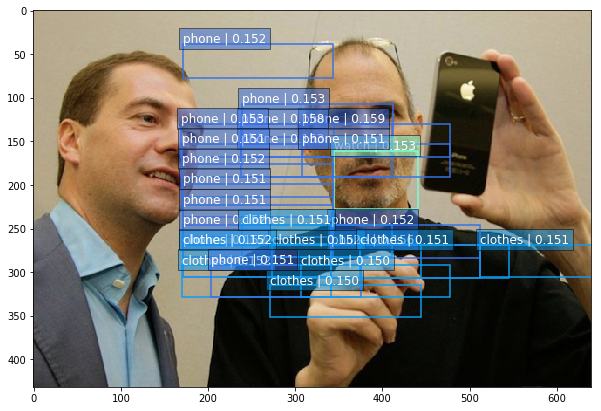

In [12]:
# 最后在原图img上，显示结果
visualization.plt_bboxes(img, classes, scores, bboxes)